In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


In [2]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(224, 224)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder, 
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',  # Multi-class classification
        subset='training',
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [3]:
# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\fix_image_processing'

In [4]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 1607 images belonging to 3 classes.
Found 401 images belonging to 3 classes.
Class indices: {'mengantuk': 0, 'menguap': 1, 'tidak_mengantuk': 2}


In [5]:
# Model MobileNet
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze sebagian besar layer
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Tambahkan head model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
# Input shape dan jumlah kelas
input_shape = (224, 224, 3)
num_classes = 3  # mengantuk, menguap, tidak_mengantuk

In [7]:
# Inisialisasi model
model = build_mobilenet_model(input_shape, num_classes)

In [8]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [9]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [10]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)



=== Training Model ===


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6975 - loss: 3.2730 - val_accuracy: 0.9701 - val_loss: 2.2468
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9527 - loss: 2.2241 - val_accuracy: 0.9875 - val_loss: 1.9513
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9754 - loss: 1.9064 - val_accuracy: 0.9800 - val_loss: 1.7136
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9890 - loss: 1.6496 - val_accuracy: 0.9800 - val_loss: 1.4936
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9859 - loss: 1.4456 - val_accuracy: 0.9850 - val_loss: 1.2919
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9784 - loss: 1.2631 - val_accuracy: 0.9850 - val_loss: 1.1208
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9885 - loss: 1.0906 - val_accuracy: 0.9875 - val_loss: 0.9701
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9919 - loss: 0.9357 - val_accuracy: 0.9875 - v


=== Evaluasi Model ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9913 - loss: 0.1295
Validation Loss: 0.1258
Validation Accuracy: 0.9900
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
mengantuk: Optimal Threshold = 0.3320
menguap: Optimal Threshold = 0.3433
tidak_mengantuk: Optimal Threshold = 0.5419


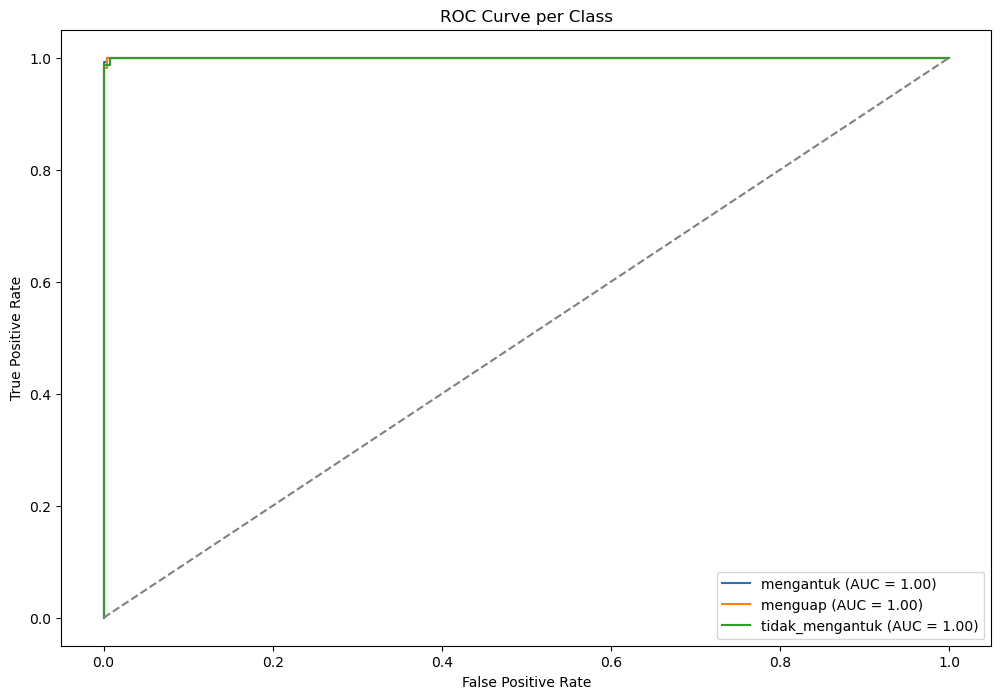

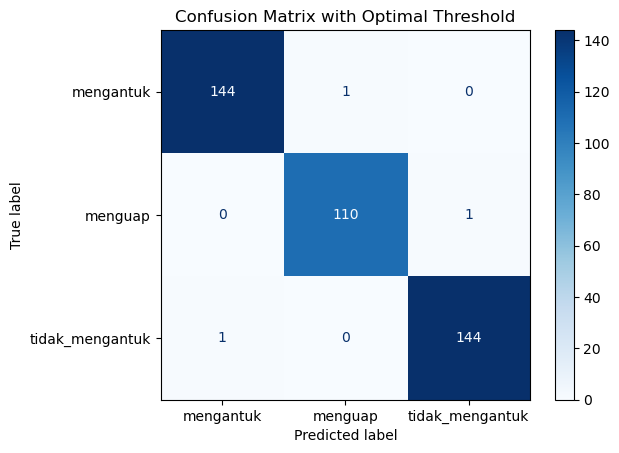


Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

      mengantuk       0.99      0.99      0.99       145
        menguap       0.99      0.99      0.99       111
tidak_mengantuk       0.99      0.99      0.99       145

       accuracy                           0.99       401
      macro avg       0.99      0.99      0.99       401
   weighted avg       0.99      0.99      0.99       401



In [12]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Confusion Matrix
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = validation_generator.classes

# ROC Curve dan Optimal Threshold untuk setiap kelas
optimal_thresholds = []
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(train_generator.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Cari threshold optimal
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    print(f"{class_name}: Optimal Threshold = {optimal_threshold:.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc='lower right')
plt.show()

# Update Prediksi Menggunakan Optimal Threshold
y_pred_optimal = np.zeros_like(y_probs)

# Terapkan threshold optimal untuk setiap kelas
for i, threshold in enumerate(optimal_thresholds):
    y_pred_optimal[:, i] = (y_probs[:, i] > threshold).astype(int)

# Pilih kelas dengan skor tertinggi setelah thresholding
y_pred_optimal_class = np.argmax(y_pred_optimal, axis=1)

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal_class)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=list(train_generator.class_indices.keys()))
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal_class, target_names=list(train_generator.class_indices.keys())))


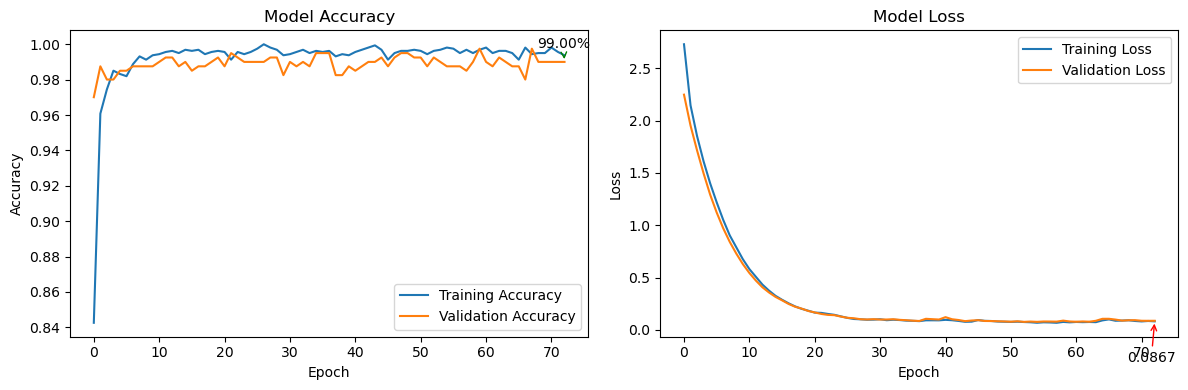

In [13]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Tambahkan anotasi akurasi validasi terakhir
final_val_accuracy = history.history['val_accuracy'][-1]
plt.annotate(f'{final_val_accuracy * 100:.2f}%', 
             xy=(len(history.history['val_accuracy']) - 1, final_val_accuracy), 
             xytext=(-20, 10), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='green'))

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Tambahkan anotasi loss validasi terakhir
final_val_loss = history.history['val_loss'][-1]
plt.annotate(f'{final_val_loss:.4f}', 
             xy=(len(history.history['val_loss']) - 1, final_val_loss), 
             xytext=(-20, -30), textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
model.save('mobilenet_rgb_2.h5')
print("Model telah disimpan dalam format .h5")

Model telah disimpan dalam format .h5


In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "mobilenet_rgb.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
        right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
        mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

        return {
            "left_eye": np.expand_dims(left_eye, axis=0),
            "right_eye": np.expand_dims(right_eye, axis=0),
            "mouth": np.expand_dims(mouth, axis=0),
            "left_eye_pred": left_eye_pred,
            "right_eye_pred": right_eye_pred,
            "mouth_pred": mouth_pred,
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\merem.jpg", "D:\\pcv\\test data\\menguap.jpeg"]

# Perbaharui proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        left_eye_pred = rois["left_eye_pred"]
        right_eye_pred = rois["right_eye_pred"]
        mouth_pred = rois["mouth_pred"]

        # Gabungkan probabilitas kelas "Mengantuk" dan "Menguap"
        mengantuk = (left_eye_pred[0] + left_eye_pred[1] +
                     right_eye_pred[0] + right_eye_pred[1] +
                     mouth_pred[0] + mouth_pred[1]) / 3
        tidak_mengantuk = (left_eye_pred[2] +
                           right_eye_pred[2] +
                           mouth_pred[2]) / 3

        # Tentukan label dan confidence
        if mengantuk > tidak_mengantuk:
            label = "Mengantuk"
            confidence = mengantuk
        else:
            label = "Tidak Mengantuk"
            confidence = tidak_mengantuk

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


Model berhasil dimuat dari: mobilenet_rgb.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Image: D:\pcv\test data\merem.jpg
Predicted Label: Tidak Mengantuk (Confidence: 0.88)

Gambar tidak ditemukan: D:\pcv\test data\menguap.jpeg


In [46]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "mobilenet_rgb.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

# Fungsi untuk memproses mata dan mulut
def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (224, 224), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(np.expand_dims(left_eye, axis=0))[0]
        right_eye_pred = model.predict(np.expand_dims(right_eye, axis=0))[0]
        mouth_pred = model.predict(np.expand_dims(mouth, axis=0))[0]

        return {
            "left_eye_pred": left_eye_pred,
            "right_eye_pred": right_eye_pred,
            "mouth_pred": mouth_pred,
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\projek\\CNN_Deteksi_Kantuk\\dataset_2\\Closed\\_2.jpg", "D:\\pcv\\test data\\merem.jpeg"]

# Threshold untuk masing-masing kelas (coba lebih rendah)
THRESHOLD_MENGANTUK = 0.3   # Turunkan threshold untuk mengantuk
THRESHOLD_MENGUAP = 0.3    # Turunkan threshold untuk menguap
THRESHOLD_TIDAK_MENGANTUK = 0.7  # Sesuaikan threshold untuk tidak mengantuk

# Proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        left_eye_pred = rois["left_eye_pred"]
        right_eye_pred = rois["right_eye_pred"]
        mouth_pred = rois["mouth_pred"]

        # Hitung rata-rata prediksi untuk masing-masing label
        mengantuk = (left_eye_pred[0] + right_eye_pred[0] + mouth_pred[0]) / 3
        menguap = (left_eye_pred[1] + right_eye_pred[1] + mouth_pred[1]) / 3
        tidak_mengantuk = (left_eye_pred[2] + right_eye_pred[2] + mouth_pred[2]) / 3

        # Debugging Output
        print(f"Left Eye Prediction: {left_eye_pred}")
        print(f"Right Eye Prediction: {right_eye_pred}")
        print(f"Mouth Prediction: {mouth_pred}")
        print(f"Predictions - Mengantuk: {mengantuk}, Menguap: {menguap}, Tidak Mengantuk: {tidak_mengantuk}")

        # Tentukan label dan confidence berdasarkan threshold
        if mengantuk >= THRESHOLD_MENGANTUK:
            label = "Mengantuk"
            confidence = mengantuk
        elif menguap >= THRESHOLD_MENGUAP:
            label = "Menguap"
            confidence = menguap
        elif tidak_mengantuk >= THRESHOLD_TIDAK_MENGANTUK:
            label = "Tidak Mengantuk"
            confidence = tidak_mengantuk
        else:
            label = "Tidak Terdefinisi"
            confidence = 0

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


Model berhasil dimuat dari: mobilenet_rgb.h5
No face detected in image: D:\projek\CNN_Deteksi_Kantuk\dataset_2\Closed\_2.jpg
Gagal memproses gambar: D:\projek\CNN_Deteksi_Kantuk\dataset_2\Closed\_2.jpg

Gambar tidak ditemukan: D:\pcv\test data\merem.jpeg
